In [11]:
import torch 
from torch import nn 
from dataloader import * 
from test2 import generate_batch_prototypes

dataloader, dlen = dataloader('C:/Users/gugu1/Documents/GitHub/swipetest/experiments/processed_gesture_data.json', batch_size=20, test_size=2, mode='train')



# for i, (data, labels) in enumerate(dataloader):
#     print(data)
#     print(labels)
    



In [12]:
# def take_out_t(data):
#     newdata = data[:, :, :-1]  # Mantém apenas as duas primeiras colunas (x, y)
#     return newdata

print(next(iter(dataloader)))

[tensor([[[ 0.9124, -0.7049,  1.0000],
         [ 0.9075, -0.7131,  1.0000],
         [ 0.9075, -0.7131,  1.0000],
         ...,
         [-0.5474, -0.3033,  1.0000],
         [-0.5474, -0.2787,  1.0000],
         [-0.5377, -0.2787,  1.0000]],

        [[ 0.6722, -0.8000,  1.0000],
         [ 0.6722, -0.8000,  1.0000],
         [ 0.6667, -0.7909,  1.0000],
         ...,
         [-0.4889, -0.6727,  1.0000],
         [-0.4889, -0.6909,  1.0000],
         [-0.4833, -0.7182,  1.0000]],

        [[-0.4915, -0.2116,  1.0000],
         [-0.5011, -0.2116,  1.0000],
         [-0.5107, -0.2116,  1.0000],
         ...,
         [-0.7088, -0.1060,  1.0000],
         [-0.7115, -0.0965,  1.0000],
         [-0.7143, -0.0871,  1.0000]],

        ...,

        [[ 0.8222, -0.1280,  1.0000],
         [ 0.8185, -0.1343,  1.0000],
         [ 0.8054, -0.1535,  1.0000],
         ...,
         [ 0.8314, -0.1786,  1.0000],
         [ 0.8426, -0.1754,  1.0000],
         [ 0.8500, -0.1754,  1.0000]],

        [

In [349]:
print(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

cuda


In [398]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Encoder Stack
        self.dilation_depth = 3
        self.n_rep = 4
        self.tanh_conv = []
        self.sigmoid_conv = []
        self.skip_scale = []
        self.res_scale = []
        self.n_res = 64*3
        self.n_skip = 32*2
        dilations = [2**i for i in range(self.dilation_depth)] * self.n_rep
        for d in dilations:
            self.tanh_conv.append(nn.Conv1d(self.n_res, self.n_res, 2, dilation=d, padding = 'same'))
            self.sigmoid_conv.append(nn.Conv1d(self.n_res, self.n_res, 2, dilation=d, padding='same'))
            self.skip_scale.append(nn.Conv1d(self.n_res, self.n_skip, 1, padding = 'same'))
            self.res_scale.append(nn.Conv1d(self.n_res, self.n_res, 1, padding = 'same'))

        self.tanh_conv = nn.Sequential(*self.tanh_conv)
        self.sigmoid_conv = nn.Sequential(*self.sigmoid_conv)
        self.skip_scale = nn.Sequential(*self.skip_scale)
        self.res_scale = nn.Sequential(*self.res_scale)

        self.pre_layer = nn.Conv1d(2, self.n_res, 1, padding = 'same')
        self.post_stack = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(self.n_skip, self.n_skip, 1, padding='same'),
            nn.ReLU(),
            nn.Conv1d(self.n_skip, 2, 1, padding= 'same'),
            nn.Tanh()
        )


    def forward(self, prototypes):

        prototypes = prototypes.permute(0, 2, 1)
        x = self.pre_layer(prototypes)
        prev = 0 
        skip_connections = []
        for s, t, skip, res in zip(self.sigmoid_conv, self.tanh_conv, self.skip_scale, self.res_scale):
            x_t = torch.tanh(t(x))
            x_s = torch.sigmoid(s(x))
            x = x_t * x_s
            skip = skip(x)
            res = res(x)
            x = res + x[:, :, -res.size(2):]
            skip_connections.append(skip)
        x = sum(skip_connections)
        output = self.post_stack(x)

        output = output.permute(0, 2, 1)
        return output
        


In [399]:
def loss_function(recon_x, x):
   MSE = nn.MSELoss()
   return MSE(recon_x, x)
   
def train(model, dataloader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    model.train()
    for epoch in range(epochs):
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            if any(len(label) == 0 for label in labels):
                print('Empty label found, skipping this batch.')
                continue  # Pula para o próximo lote se encontrar label vazia
            data = take_out_t(data)
            prototypes = generate_batch_prototypes(labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            
            noise = model(prototypes)
            recon_data = prototypes + noise 
            loss = loss_function(recon_data, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}')
    return model

In [400]:
model = Model().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

model = train(model, dataloader, epochs=10)

Epoch: 0, Loss: 0.07964885234832764
Epoch: 0, Loss: 0.046822693198919296
Epoch: 0, Loss: 0.07065831869840622
Epoch: 0, Loss: 0.07060535997152328
Epoch: 0, Loss: 0.06512968987226486
Epoch: 0, Loss: 0.0644751563668251
Epoch: 0, Loss: 0.06481575220823288
Epoch: 0, Loss: 0.05721902474761009
Epoch: 0, Loss: 0.05270365625619888
Epoch: 0, Loss: 0.07147952169179916
Epoch: 0, Loss: 0.044294584542512894
Epoch: 0, Loss: 0.1040751114487648
Epoch: 0, Loss: 0.05893927812576294
Epoch: 0, Loss: 0.059155311435461044
Epoch: 0, Loss: 0.07874717563390732
Epoch: 0, Loss: 0.07686462253332138
Epoch: 0, Loss: 0.09224946051836014
Epoch: 0, Loss: 0.0847526416182518
Epoch: 0, Loss: 0.059156227856874466
Epoch: 0, Loss: 0.05501950904726982
Epoch: 0, Loss: 0.0726340189576149
Epoch: 0, Loss: 0.05590632185339928
Epoch: 0, Loss: 0.09302717447280884
Epoch: 0, Loss: 0.08656305074691772
Epoch: 0, Loss: 0.06370934098958969
Epoch: 0, Loss: 0.052854400128126144
Epoch: 0, Loss: 0.04816227778792381
Epoch: 0, Loss: 0.047946508

In [385]:
data, labels = next(iter(dataloader))
data[0].shape

torch.Size([128, 3])

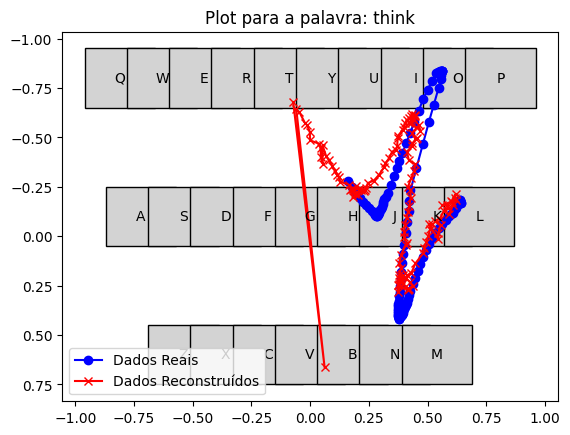

In [788]:
import matplotlib.pyplot as plt
import numpy as np

# Teclado padrão
keyboard_layout = [
    ['Z','X','C','V','B','N','M'],
    ['A','S','D','F','G','H','J','K','L'],
    ['Q','W','E','R','T','Y','U','I','O','P'],
]

ASPECT_RATIO = 1  # Relação altura/largura do teclado
key_size = 0.3  # Tamanho visual de cada tecla

# Função para calcular os centros das teclas com espaçamento adequado
def get_key_centers():
    key_centers = {}

    # Dimensões normalizadas do teclado
    width = 2.0  # Variando de -1 a 1 no eixo X
    height = width * ASPECT_RATIO  # Ajusta a altura de acordo com o aspecto

    # Espaçamento entre teclas
    padding_x = width * 0.05  # Reduzi o padding para 5%
    padding_y = height * 0.05

    # Largura e altura das teclas
    key_width = (width - 2 * padding_x) / 10  # Considera a linha de 10 teclas
    key_height = (height - 2 * padding_y) / 3  # Três linhas de teclas

    for row_idx, row in enumerate(keyboard_layout):
        # Calcula a coordenada Y para cada linha
        y = 1 - padding_y - row_idx * (key_height + padding_y) - key_height / 2

        # Calcula o padding para centralizar linhas menores
        row_padding_x = (width - len(row) * key_width) / 2

        for key_idx, key in enumerate(row):
            # Calcula a coordenada X para cada tecla
            x = -1 + row_padding_x + key_idx * key_width + key_width / 2
            key_centers[key] = np.array([x, y])

    return key_centers, width, height

# Função para mapear a palavra para os centros das teclas
def map_word_to_centers(word, key_centers):
    word = word.upper()
    centers = []

    for char in word:
        if char in key_centers:
            centers.append(key_centers[char])
        else:
            raise ValueError(f"Caractere '{char}' não está presente no teclado.")
    
    return np.array(centers)

# Função para desenhar o teclado
def plot_keyboard(ax):
    key_centers, _, _ = get_key_centers()
    
    for key, center in key_centers.items():
        rect = plt.Rectangle((center[0] - key_size / 2, center[1] - key_size / 2), key_size, key_size, edgecolor='black', facecolor='lightgray')
        ax.add_patch(rect)
        ax.text(center[0], center[1], key, ha='center', va='center', fontsize=10)

# Função para plotar os dados e reconstruções
def plot(data, recon_data, word):
    fig, ax = plt.subplots()
    
    # Inverter o eixo Y apenas no dado reconstruído, para alinhar com o sistema de coordenadas da tela
    data[:, 1] = data[:, 1]
    recon_data[:, 1] = -recon_data[:, 1]

    data = data.detach().cpu().numpy()
    recon_data = recon_data.detach().cpu().numpy()
    # Plotar o teclado
    plot_keyboard(ax)
    
    # Plotar os dados reais
    ax.plot(data[:, 0], data[:, 1], 'o-', label='Dados Reais', color='blue')
    
    # Plotar os dados reconstruídos
    ax.plot(recon_data[0, :, 0], recon_data[0, :, 1], 'x-', label='Dados Reconstruídos', color='red')
    
    # Customizar a plotagem
    ax.set_title(f'Plot para a palavra: {word}')
    ax.legend()
    ax.invert_yaxis()  # Inverte o eixo Y para que o teclado e o gesto estejam na mesma direção
    plt.show()

# Código para executar com dados de exemplo
data, labels = next(iter(dataloader))
data = data[0]
labels = labels[0]
prototypes = generate_batch_prototypes([labels])
recon_data = inference(model, prototypes).cpu()
plot(data, recon_data, labels)
